# Intro

This piece of work is inspired by a [youtube video lecture](https://www.youtube.com/watch?v=vaL1I2BD_xY) by Martin Gorner, a Google developer 
who put forth this idea of combining YOLO grid with SqueezeNet (instead of DarkNet - original stack for [YOLO](https://arxiv.org/pdf/1506.02640.pdf)). Original paper states - " Our model struggles with small objects that appear in groups, such as flocks of birds.", but it seems that YOLO can be useful for swarm type things as well.

In [1]:
import os
import sys
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = seed

In [2]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3

TRAIN_PATH = '/home/djn/Datasets/kaggle2018/stage1_train/'
TEST_PATH = '/home/djn/Datasets/kaggle2018/stage1_test/'

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [5]:
# Resize train images.
print('resize train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img = imread(os.path.join(path, 'images', id_ + '.png'))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    train_images[n] = img

resize train images... 


100%|██████████| 670/670 [00:49<00:00, 13.66it/s]


In [6]:
# Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_ + '.png'))[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

resize test images ... 


100%|██████████| 65/65 [00:03<00:00, 19.51it/s]

Done!


In [7]:
# Given mask image, training image id, mask id and rotation id (0 to 3),
# we generate ground truth labels.
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    # Uses open cv to find object in mask images.
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict

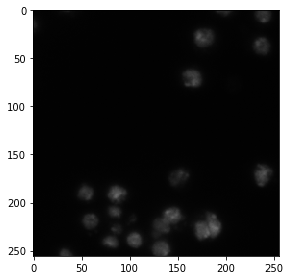

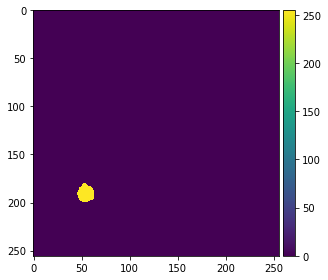

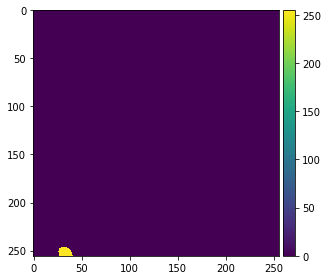

In [8]:
img = imread(os.path.join(TRAIN_PATH, "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png"))
plt.figure()
imshow(img)

maskImg = imread(os.path.join(TRAIN_PATH, "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png"))
plt.figure()
imshow(maskImg)

maskImg = imread(os.path.join(TRAIN_PATH, "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png"))
plt.figure()
imshow(maskImg)


In [9]:
# Generates boundinx box (labels) ground truth.
# The labels are based on mask files included in training dataset.
# Mask files are images showing objects in training images.

path_bboxes_csv = os.path.join(TRAIN_PATH, 'bboxes.csv')
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = os.path.join(TRAIN_PATH, id_)
        for mask_id, mask_file in enumerate(os.listdir(os.path.join(path, 'masks'))):
            mask_ = imread(os.path.join(path, 'masks', mask_file))
            # To augment training dataset, we rotate mask data.
            for r in range(4):
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)

In [10]:
# Define grid cell size.
GRID_DIM = 8
# The width/height of a grid in pixel.
GRID_PIX = IMG_WIDTH//GRID_DIM
BATCH_SIZE = 10

In [11]:
train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_ids_df.loc[cnt] = { "idx": n, "id_": id_}
    cnt += 1

train_ids_df = train_ids_df.set_index(['idx'])

100%|██████████| 670/670 [00:01<00:00, 342.54it/s]


In [12]:
# Grid-based coordinates of box (top-left corner).
bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

# The center coordinates of the grid this box is located at.
bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

# The center coordinates of box center.
bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

# Here there is an object we know. So set object confidence to 1.
bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h

In [13]:
mask_count = 1
#Set maximum bounding boxes allowed per grid cell
MAX_BB_CNT = 2

In [14]:
# Returns the label for a given training image id and rotation id.
def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    # Initialize the label ground truth.
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

In [15]:
# Returns label ground truth for input data.
# The dimension is (batch size, grid width, grid height, predicted boxes per cell, variables per box).
def get_labels(counts, rotations):
    grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)
    for i, c in enumerate(counts):
        tr_id = train_ids_df.loc[c, 'id_']
        grid_info[i] = get_grid_info(tr_id, rotations[i])
    grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
    return nd.array(grid_info)

In [16]:
def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])
    images = np.transpose(images, (0, 3, 1, 2))
    return nd.array(images)

In [17]:
def next_batch():
    rotations = []
    rand_counts = []
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 669))
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

In [18]:
class process_logits(nn.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def hybrid_forward(self, F, x):
        out = F.reshape(x, (-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5))
        res = F.stack(
            F.tanh(out[:, :, :, :, 0]),
            F.tanh(out[:, :, :, :, 1]),
            F.sqrt(F.sigmoid(out[:, :, :, :, 2])),
            F.sqrt(F.sigmoid(out[:, :, :, :, 3])),
            F.sigmoid(out[:, :, :, :, 4]), axis=4
        )
        
        return res

In [75]:
class normalize_yolo_loss(gluon.loss.Loss):
    def __init__(self, coords, noobj, weight=None, batch_axis=0):
        super().__init__(None, batch_axis=0)
        self.noobj = noobj
        self.coords = coords
        
    def hybrid_forward(self, F, preds, labels):
        obj_mask = labels[:, :, :, :, 4]
        noobj_mask = 1.0 - labels[:, :, :, :, 4]
        #print(obj_mask.shape, preds[:, :, :, :, 4].shape)
        
        delta = F.square(preds - labels)
        confs = delta[:, :, :, :, 4]
        #print(confs.shape)
        obj_conf = F.square(1.0 - preds[:, :, :, :, 4]) * obj_mask
        noobj_conf = F.square(0.0 - preds[:, :, :, :, 4]) * noobj_mask * self.noobj
        
        conf_loss = F.sum(obj_conf + noobj_conf, axis=[1, 2, 3])
        
        box_loss = F.sum(delta[:, :, :, :, :4] * F.expand_dims(obj_conf, axis=4),
                         axis=[1, 2, 3, 4]) * self.coords
        
        loss = conf_loss + box_loss
        
        return F.mean(loss, axis=0)
        

In [76]:
class fire_module(nn.HybridBlock):
    def __init__(self, squeeze_dim, expand_dim, **kwargs):
        super(fire_module, self).__init__(**kwargs)
        self.squeeze_dim = squeeze_dim
        self.expand_dim = expand_dim
        with self.name_scope():
            self.sqconv = nn.Conv2D(squeeze_dim, kernel_size=1, strides=1)
            self.bn1 = nn.BatchNorm()
            self.lrelu1 =  nn.LeakyReLU(alpha=0.1)
            
            self.exconv1 = nn.Conv2D(expand_dim, kernel_size=3, strides=1, padding=1)
            self.bn21 = nn.BatchNorm()
            self.lrelu21 = nn.LeakyReLU(alpha=0.1)
            
            self.exconv2 = nn.Conv2D(expand_dim, kernel_size=1, strides=1)
            self.bn22 = nn.BatchNorm()
            self.lrelu22 = nn.LeakyReLU(alpha=0.1)
            
    def hybrid_forward(self, F, x):
        squeezed = self.sqconv(x)
        squeezed = self.bn1(squeezed)
        squeezed = self.lrelu1(squeezed)
        
        expanded_1 = self.exconv1(squeezed)
        expanded_1 = self.bn21(expanded_1)
        expanded_1 = self.lrelu21(expanded_1)
        
        expanded_2 = self.exconv2(squeezed)
        expanded_2 = self.bn22(expanded_2)
        expanded_2 = self.lrelu22(expanded_2)
        
        return F.concat(expanded_1, expanded_2, dim=1)

In [77]:
ctx = mx.gpu()

In [78]:
net = nn.HybridSequential()
with net.name_scope():
    net.add(nn.Conv2D(32, 1),
           nn.BatchNorm(),
           nn.LeakyReLU(alpha=0.1))
    net.add(nn.MaxPool2D())

    net.add(fire_module(32, 64))
    net.add(fire_module(32, 64))
    net.add(fire_module(32, 64))

    net.add(nn.MaxPool2D())

    net.add(fire_module(64, 96))
    net.add(fire_module(64, 96))
    net.add(fire_module(64, 96))

    net.add(nn.MaxPool2D())

    net.add(fire_module(128, 160))
    net.add(fire_module(128, 160))
    net.add(fire_module(128, 160))

    net.add(nn.MaxPool2D())

    net.add(fire_module(256, 512))
    net.add(fire_module(256, 512))
    net.add(fire_module(256, 512))

    net.add(nn.MaxPool2D())

    net.add(fire_module(512, 1024))
    net.add(fire_module(512, 1024))
    net.add(fire_module(512, 1024))

    net.add(nn.Conv2D(MAX_BB_CNT*5*8, 1),
           nn.BatchNorm(),
           nn.GlobalAvgPool2D())

    net.add(nn.Dense(GRID_DIM * GRID_DIM * MAX_BB_CNT * 5))

    net.add(process_logits())

net.initialize(ctx=ctx)

In [79]:
loss_fn = normalize_yolo_loss(coords=5.0, noobj=0.5)
lr_sked = mx.lr_scheduler.FactorScheduler(step=500, factor=0.4)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0001,
                                                      'lr_scheduler': lr_sked})

In [80]:
start_training = True
if not start_training:
    test_image_id = 33
    result = net(test_images[test_image_id])

In [ ]:
if(start_training):
    # initialize
    batch_count = 0
    display_count = 1
    global mask_count

    for ep in range(10):
        loss_rec = nd.array([0.], ctx=ctx)
        print("Current Learning rate ", trainer.learning_rate)
    
        for i in range(690):
            batch_X, batch_Y = next_batch()
            batch_X = batch_X.as_in_context(ctx)
            batch_Y = batch_Y.as_in_context(ctx)

            batch_count += 1

            with autograd.record():
                logits = net(batch_X)
                loss = loss_fn(logits, batch_Y)

            loss.backward()
            trainer.step(batch_X.shape[0])
            
            loss_rec += loss
          #  print(loss.shape)
            if(i % 100 == 0):
                print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(loss_rec.asscalar() / (i+1)))
                display_count +=1
            mask_count = 0
    print("Done!")

1 training loss(623): 36.59813690185547
2 training loss(575): 31.932092647741335
3 training loss(545): 30.742216651119403
4 training loss(264): 30.049477003737543
5 training loss(212): 29.327798667394013
6 training loss(268): 28.566743466192616
7 training loss(437): 28.101260269342763
8 training loss(591): 24.89617347717285
9 training loss(382): 24.422646097617573
10 training loss(417): 24.367445001554728
11 training loss(631): 24.344488099563954
12 training loss(585): 24.272292900561098
13 training loss(465): 24.03092837761976
14 training loss(437): 23.889510321339433
15 training loss(355): 22.956022262573242
16 training loss(557): 22.840646271658414
17 training loss(209): 22.993249086598258
18 training loss(476): 23.003589921615447
19 training loss(228): 23.10273875857232
20 training loss(408): 23.02726188248503
21 training loss(567): 23.03297888935108
22 training loss(323): 24.460922241210938
23 training loss(238): 22.756550703898515
24 training loss(532): 22.69795796408582
25 train

In [ ]:
if start_training:
    test_image_id = 3
    test_img = nd.array(test_images[test_image_id], ctx=ctx).transpose((2, 0, 1)).expand_dims(0)
    result = net(test_img)

In [ ]:
boxes = result.asnumpy()
print(boxes.shape)
boxes = np.reshape(boxes, newshape=[GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
bbs = []

for i in range(GRID_DIM):
    for j in range(GRID_DIM):
        for b in range(MAX_BB_CNT):
            if(boxes[i][j][b][4]> 0.75):
                grid_center_x = ((j+0)*GRID_PIX + GRID_PIX/2)
                grid_center_y = ((i+0)*GRID_PIX + GRID_PIX/2)
                
                new_box_center_x = boxes[i][j][b][0] * IMG_WIDTH + grid_center_x
                new_box_center_y = boxes[i][j][b][1] * IMG_HEIGHT + grid_center_y

                new_w = np.square(boxes[i][j][b][2]) * IMG_WIDTH
                new_h = np.square(boxes[i][j][b][3]) * IMG_HEIGHT
                
                x1 = new_box_center_x - new_w/2
                y1 = new_box_center_y - new_h/2

                x2 = new_box_center_x + new_w/2
                y2 = new_box_center_y + new_h/2

                bbs.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))

In [ ]:
img = test_images[test_image_id]
f, axs = plt.subplots(1,2)
axs[0].imshow(img)

img_withbbox = np.copy(img)
#imshow(img)
for i, b in enumerate(bbs):
    cv2.rectangle(img_withbbox,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

axs[1].imshow(img_withbbox)